In [2]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy import signal
import pickle

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [3]:
### Load Luke Mean ###
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

In [4]:
### Load JFRC2018 ###
fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

In [5]:
################################
### Load voxel-res corr data ###
################################

dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210420_correlation/"
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    brainsss.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    brainsss.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    r_map = np.reshape(r_map, (49,256,128))
    p_map = np.reshape(p_map, (49,256,128))
    
    r_map[p_map >= 1e-4]=0
    
    maps[behavior] = r_map
    
############################################
### Put into plotting format with colors ###
############################################

slices = []
for z in range(49):
    colors1 = maps['Z_neg'][z,:,:].T
    colors2 = maps['Z_pos'][z,:,:].T
    colors3 = maps['Y_pos'][z,:,:].T
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
slices = np.asarray(slices)

func = np.swapaxes(slices, 0, 2)
func.shape

moving = ants.from_numpy(func[:,:,::-1,:])
moving.set_spacing((2.6076, 2.6154, 5.3125, 1)) ### matching this to the slightly off luke mean
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')
maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], imagetype=3, interpolator='nearestNeighbor')
maps_voxel_res.shape

(314, 146, 91, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


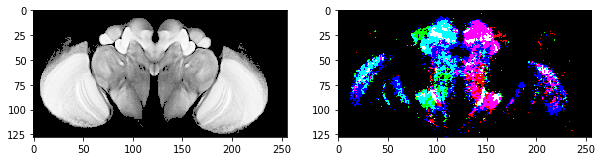

In [98]:
plt.figure(figsize=(10,10))
z=22
plt.subplot(1,2,1)
plt.imshow(np.swapaxes(luke_mean_lowres[:,:,z],0,1),cmap='Greys_r')
plt.subplot(1,2,2)
plt.imshow(np.swapaxes(moving[:,:,z,:]*100,0,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


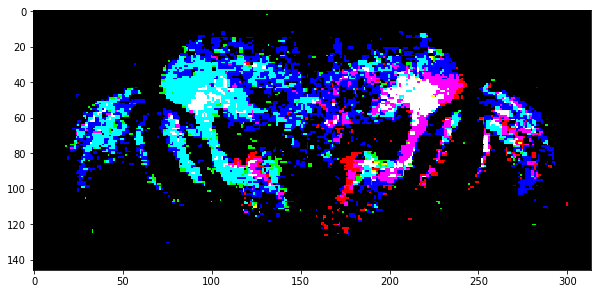

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(maps_voxel_res[:,:,65,:]*100,0,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


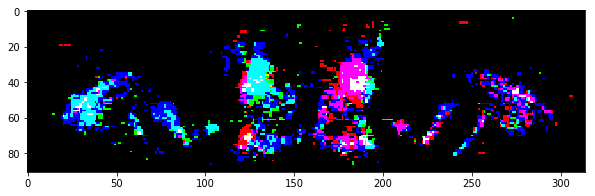

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(maps_voxel_res[:,80,:,:]*100,0,1))

In [15]:
fixed_lowres

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (314, 146, 91)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [6]:
FDA_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine_zflip_2umiso.nii'
FDA = np.asarray(nib.load(FDA_file).get_data().squeeze(), dtype='float32')
FDA = FDA[:,:,::-1]

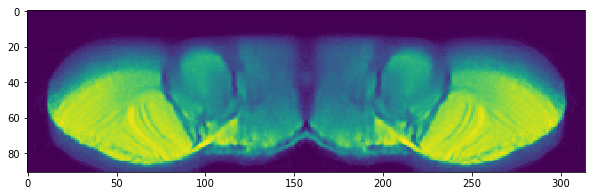

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(FDA[:,80,:].T)

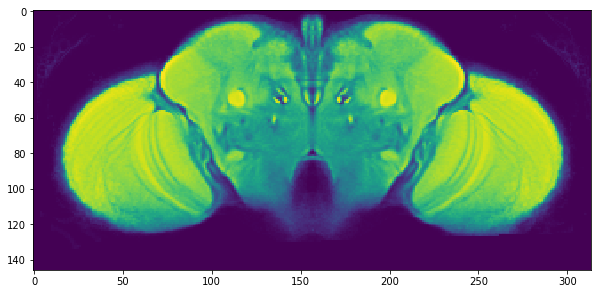

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(FDA[:,:,65].T)

In [8]:
connectome_dir = '/oak/stanford/groups/trc/data/Brezovec/20220620_connectome'
connectome_adj_file = os.path.join(connectome_dir, 'adj.h5')

In [17]:
with h5py.File(connectome_adj_file,'r') as handle:
    print(list(handle.keys()))
    grids_x = handle['grids_x'][:]
    grids_y = handle['grids_y'][:]
    grids_z = handle['grids_z'][:]
    voxel_size_connectome = handle['voxel_size'][:][0]

['adj', 'grids_x', 'grids_y', 'grids_z', 'voxel_size']


In [40]:
print(grids_x[0],grids_x[-1])
print(grids_y[0],grids_y[-1])
print(grids_z[0],grids_z[-1])

0.248 280.248
59.160000000000004 304.1599999999997
23.608 323.608


In [28]:
# now lets see what axes and their directions makes sense...
voxel_size_func = 2.0
grids_x_func_space = grids_x/voxel_size_func
grids_y_func_space = grids_y/voxel_size_func
grids_z_func_space = grids_z/voxel_size_func

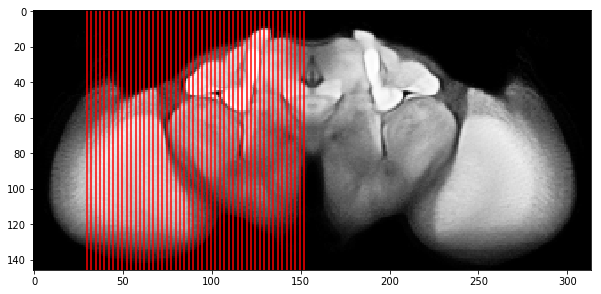

In [51]:
plt.figure(figsize=(10,10))
plt.imshow(FDA[:,:,40].T,cmap='Greys_r')
for gridline in grids_y_func_space:
    plt.axvline(gridline,color='r')

In [ ]:
# FDA is (314,146,91) at 2um iso. Lets call these axes (X,Y,Z)
# grids_z is actually X 


In [61]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_189/func_2/'

In [62]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

### Get Metadata ###
stim_ids, angles = brainsss.get_stimulus_metadata(vision_path)
print(F"Found {len(stim_ids)} presented stimuli.")

# *100 puts in units of 10ms, which will match fictrac
starts_angle = {}
for angle in [0,180]:
    starts_angle[angle] = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == angle]
print(F"starts_angle_0: {len(starts_angle[0])}. starts_angle_180: {len(starts_angle[180])}")

# get 1ms version to match neural timestamps
starts_angle_ms = {}
for angle in [0,180]:
    starts_angle_ms[angle] = [i*10 for i in starts_angle[angle]]

loading photodiode data... done
Loaded from Pickle.
Found 741 presented stimuli.
starts_angle_0: 184. starts_angle_180: 184


In [65]:
fname = [x for x in os.listdir(vision_path) if '.hdf5' in x][0]
visprotocol_file = os.path.join(vision_path, fname)
with h5py.File(visprotocol_file, 'r') as file:
    angles = list(file['angle'][:])

In [66]:
angles

[0.0,
 180.0,
 180.0,
 0.0,
 0.0,
 180.0,
 180.0,
 0.0,
 180.0,
 180.0,
 0.0,
 0.0,
 180.0,
 nan,
 nan,
 0.0,
 180.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 180.0,
 0.0,
 180.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 180.0,
 0.0,
 0.0,
 180.0,
 0.0,
 nan,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 nan,
 0.0,
 nan,
 0.0,
 180.0,
 nan,
 nan,
 0.0,
 180.0,
 0.0,
 0.0,
 180.0,
 180.0,
 180.0,
 nan,
 0.0,
 nan,
 180.0,
 0.0,
 nan,
 0.0,
 0.0,
 180.0,
 180.0,
 nan,
 nan,
 0.0,
 0.0,
 nan,
 nan,
 0.0,
 0.0,
 180.0,
 nan,
 180.0,
 0.0,
 0.0,
 180.0,
 nan,
 180.0,
 nan,
 nan,
 180.0,
 0.0,
 nan,
 180.0,
 nan,
 0.0,
 0.0,
 0.0,
 180.0,
 0.0,
 nan,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 180.0,
 180.0,
 0.0,
 0.0,
 0.0,
 nan,
 0.0,
 180.0,
 180.0,
 nan,
 nan,
 180.0,
 0.0,
 0.0,
 0.0,
 nan,
 0.0,
 0.0,
 0.0,
 180.0,
 0.0,
 0.0,
 nan,
 0.0,
 180.0,
 180.0,
 0.0,
 180.0,
 nan,
 0.0,
 180.0,
 0.0,
 nan,
 nan,
 180.0,
 nan,
 0.0,
 180.0,
 0.0,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 nan

In [64]:
stim_ids

['ConstantBackground',
 'Translation',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'Translation',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'Translation',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'Translation',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'Translation',
 'DriftingSquareGrating',
 'Translation',
 'Translation',
 'DriftingSquareGrating',
 'Translation',
 'DriftingSquareGrating',
 'Translation',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'Translation',
 'Translation',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'DriftingSquareGrating',
 'Translation',
 'DriftingSquareGrating',
 'Dri